In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import os

import json
import gzip

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from positional_embedding import HarmonicEmbedding
from ray_sampling import RaySampler
from point_sampling import *
from dataloader.co3d_utils import *
from dataloader.CO3D_dataset import *

In [3]:
with open("D:/CO3D/teddybear/38_1655_5016/frame_annotations_file.json", 'r') as f:
    j = json.load(f)

In [4]:
with open("D:/CO3D/teddybear/118_13866_29439/frame_annotations_file.json", 'r') as f:
    j2 = json.load(f)

In [7]:
print(j[6])
print()
print(j2[0])

{'frame_number': 6, 'frame_timestamp': -1.0, 'image': {'path': 'teddybear/38_1655_5016/images/frame000007.jpg', 'size': [480, 359]}, 'depth': {'path': 'teddybear/38_1655_5016/depths/frame000007.jpg.geometric.png', 'scale_adjustment': 1.262808918952942, 'mask_path': 'teddybear/38_1655_5016/depth_masks/frame000007.png'}, 'mask': {'path': 'teddybear/38_1655_5016/masks/frame000007.png', 'mass': 38074.0}, 'viewpoint': {'R': [[-0.9959138631820679, -0.08303738385438919, -0.03550243377685547], [0.08376988768577576, -0.9962910413742065, -0.01966593973338604], [-0.033737748861312866, -0.022559616714715958, 0.9991760849952698]], 'T': [0.2900815010070801, 1.25400710105896, 6.266641616821289], 'focal_length': [2.186168277496083, 1.6350716908772787], 'principal_point': [0.0, 0.0]}}

{'frame_number': 0, 'frame_timestamp': -1.0, 'image': {'path': 'teddybear/118_13866_29439/images/frame000001.jpg', 'size': [1049, 1866]}, 'depth': {'path': 'teddybear/118_13866_29439/depths/frame000001.jpg.geometric.png'

# Positional Embedding 확인

In [36]:
# (x, y, z) ---> 3(x, y, z) * 2(sin, cos) * 10 = 60으로 변환
pe = HarmonicEmbedding(10)

pe_test = pe(torch.tensor([0, 0, 1]))
print(pe_test)
print(pe_test.shape)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0998,  0.1987,  0.3894,  0.7174,
         0.9996, -0.0584,  0.1165,  0.2315,  0.4504,  0.8043,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  0.9950,  0.9801,  0.9211,  0.6967, -0.0292, -0.9983,
         0.9932,  0.9728,  0.8928,  0.5942])
torch.Size([60])


In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [4]:
seq_imgs, seq_masks, seq_c2ws, seq_intrinsics = read_seq_data("D:/CO3D/teddybear/38_1655_5016", normalization=True)

print(len(seq_imgs), len(seq_masks), len(seq_c2ws), len(seq_intrinsics))

print(seq_imgs[0])
print(seq_masks[0])
print(seq_c2ws[0])
print(seq_intrinsics[0])

102 102 102 102
teddybear/38_1655_5016/images/frame000001.jpg
teddybear/38_1655_5016/masks/frame000001.png
[[-0.99657063 -0.00649382  0.08249117 -0.05206155]
 [ 0.00412192 -0.99957407 -0.02889113 -0.57144599]
 [ 0.08264364 -0.02845203  0.99617296 -0.66875615]
 [ 0.          0.          0.          1.        ]]
[[523.45428467   0.         179.5          0.        ]
 [  0.         294.03338623 239.5          0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


In [4]:
seq_imgs, seq_masks, seq_c2ws_unscaling, seq_intrinsics_unscaling = read_seq_data("D:/CO3D/teddybear/38_1655_5016", normalization=False)

print(len(seq_imgs), len(seq_masks), len(seq_c2ws_unscaling), len(seq_intrinsics_unscaling))

print(seq_imgs[0])
print(seq_masks[0])
print(seq_c2ws_unscaling[0])
print(seq_intrinsics_unscaling[0])

102 102 102 102
teddybear/38_1655_5016/images/frame000001.jpg
teddybear/38_1655_5016/masks/frame000001.png
[[-9.96570631e-01 -6.49381822e-03  8.24911667e-02 -3.22200772e-01]
 [ 4.12192459e-03 -9.99574066e-01 -2.88911326e-02  1.48338460e+00]
 [ 8.26436389e-02 -2.84520316e-02  9.96172959e-01 -6.38463332e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[523.45428467   0.         179.5          0.        ]
 [  0.         294.03338623 239.5          0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


Normalized Data
x : max = 0.9719414121769768, min = -0.9832789282514316
y : max = 0.8142794611715192, min = -0.7478425889349893
z : max = 0.5920736500555195, min = -0.6687561508922256
Raw Data
x : max = 2.739812759284148, min = -3.1067632551863307
y : max = 5.627034824438236, min = 0.9559166282010704
z : max = -2.614450940251105, min = -6.384633318230815


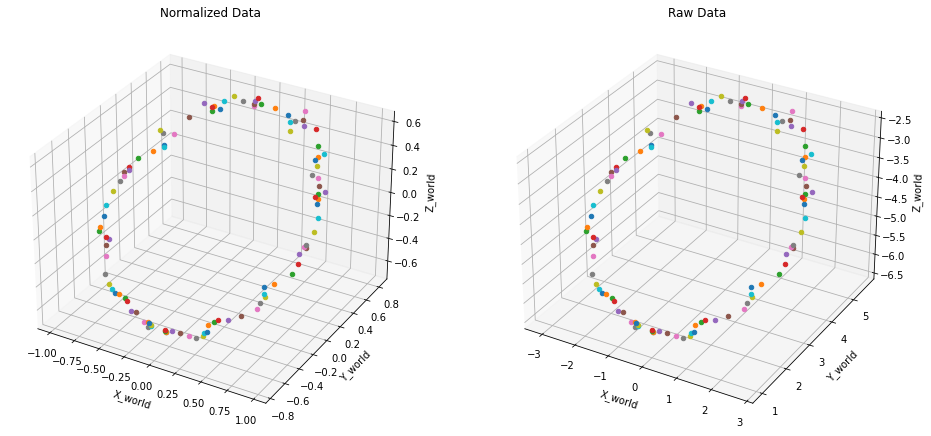

In [13]:
fig = plt.figure(figsize=(16, 9))

#####################
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_title("Normalized Data")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)

# Data for three-dimensional scattered points
xs = []
ys = []
zs = []

for seq_c2w in seq_c2ws:
    x, y, z = seq_c2w[:3, 3]
    xs.append(x)
    ys.append(y)
    zs.append(z)

    ax.scatter3D(x, y, z, cmap='Greens')

print("Normalized Data")
print(f"x : max = {max(xs)}, min = {min(xs)}")
print(f"y : max = {max(ys)}, min = {min(ys)}")
print(f"z : max = {max(zs)}, min = {min(zs)}")


#####################
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.set_title("Raw Data")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)

# Data for three-dimensional scattered points
xs = []
ys = []
zs = []

for seq_c2w in seq_c2ws_unscaling:
    x, y, z = seq_c2w[:3, 3]
    xs.append(x)
    ys.append(y)
    zs.append(z)

    ax.scatter3D(x, y, z, cmap='Greens')

print("Raw Data")
print(f"x : max = {max(xs)}, min = {min(xs)}")
print(f"y : max = {max(ys)}, min = {min(ys)}")
print(f"z : max = {max(zs)}, min = {min(zs)}")

In [14]:
category_imgs, _, _, _ = read_category_data("D:/CO3D/teddybear", normalization=False)

print(category_imgs[:10])

['teddybear/288_30468_58729/images/frame000001.jpg', 'teddybear/288_30468_58729/images/frame000002.jpg', 'teddybear/288_30468_58729/images/frame000003.jpg', 'teddybear/288_30468_58729/images/frame000004.jpg', 'teddybear/288_30468_58729/images/frame000005.jpg', 'teddybear/288_30468_58729/images/frame000006.jpg', 'teddybear/288_30468_58729/images/frame000007.jpg', 'teddybear/288_30468_58729/images/frame000008.jpg', 'teddybear/288_30468_58729/images/frame000009.jpg', 'teddybear/288_30468_58729/images/frame000010.jpg']


In [8]:
seq_index = 500
seq_name = '/'.join(category_imgs[seq_index].split('/')[:2])
print(seq_name)

_, _, seq_c2ws, seq_intrinsics = read_seq_data("D:/CO3D/" + seq_name, normalization=True)
_, _, seq_c2ws_unscaling, seq_intrinsics_unscaling = read_seq_data("D:/CO3D/" + seq_name, normalization=False)

teddybear/374_41889_83845


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


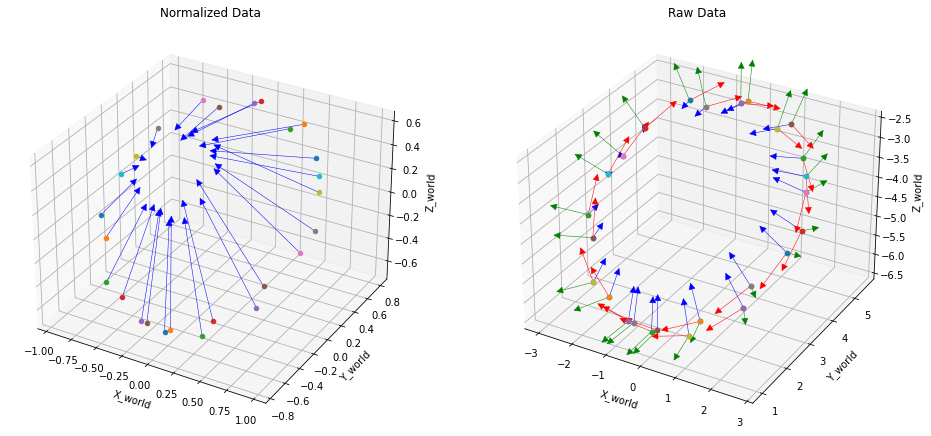

In [15]:
fig = plt.figure(figsize=(16, 9))

#####################
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_title("Normalized Data")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)

# Data for three-dimensional scattered points

for seq_c2w in seq_c2ws[::4]:
    # 카메라 위치
    x, y, z = seq_c2w[:3, 3]

    # 카메라의 +x, +y, +z축
    xx, xy, xz = seq_c2w[:3, 0]
    yx, yy, yz = seq_c2w[:3, 1]
    zx, zy, zz = seq_c2w[:3, 2]
    
    # # 카메라의 x축 그리기
    # xs = [x, x+xx]
    # ys = [y, y+xy]
    # zs = [z, z+xz]
    # a = Arrow3D(xs, ys, zs, mutation_scale=15, 
    #             lw=0.5, arrowstyle="-|>", color="r")
    # ax.add_artist(a)
    # ax.scatter3D(x, y, z, cmap='Greens')

    # # 카메라의 y축 그리기
    # xs = [x, x+yx]
    # ys = [y, y+yy]
    # zs = [z, z+yz]
    # a = Arrow3D(xs, ys, zs, mutation_scale=15, 
    #             lw=0.5, arrowstyle="-|>", color="g")
    # ax.add_artist(a)
    # ax.scatter3D(x, y, z, cmap='Greens')

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="b")
    ax.add_artist(a)
    ax.scatter3D(x, y, z, cmap='Greens')

#####################
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.set_title("Raw Data")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)

# Data for three-dimensional scattered points

for seq_c2w in seq_c2ws_unscaling[::4]:
    # 카메라 위치
    x, y, z = seq_c2w[:3, 3]

    # 카메라의 +x, +y, +z축
    xx, xy, xz = seq_c2w[:3, 0]
    yx, yy, yz = seq_c2w[:3, 1]
    zx, zy, zz = seq_c2w[:3, 2]
    
    # 카메라의 x축 그리기
    xs = [x, x+xx]
    ys = [y, y+xy]
    zs = [z, z+xz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    ax.scatter3D(x, y, z, cmap='Greens')

    # 카메라의 y축 그리기
    xs = [x, x+yx]
    ys = [y, y+yy]
    zs = [z, z+yz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="g")
    ax.add_artist(a)
    ax.scatter3D(x, y, z, cmap='Greens')

    # 카메라의 z축 그리기
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="b")
    ax.add_artist(a)
    ax.scatter3D(x, y, z, cmap='Greens')

***

# c2w 계산 과정 확인
Rotation과 Translation 값을 가지고 [ R | t ] 형태로 만든 것을 w2c로 정의.

c2w를 계산하기 위해

- w2c를 바로 inverse 시킨 값
- R^-1 = R^T, t^-1 = R^T x (-t)  ------> [ R^(-1) | t^(-1) ]

두 값이 동일한지 확인

In [32]:
with open("./test_dataset/38_1655_5016/frame_annotations_file.json", 'r') as f:
    j = json.load(f)

frame = j[0]

for frame_key in frame.keys():
    print(frame_key, frame[frame_key])

frame_number 0
frame_timestamp -1.0
image {'path': 'teddybear/38_1655_5016/images/frame000001.jpg', 'size': [479, 359]}
depth {'path': 'teddybear/38_1655_5016/depths/frame000001.jpg.geometric.png', 'scale_adjustment': 1.262808918952942, 'mask_path': 'teddybear/38_1655_5016/depth_masks/frame000001.png'}
mask {'path': 'teddybear/38_1655_5016/masks/frame000001.png', 'mass': 35984.0}
viewpoint {'R': [[-0.9965706467628479, 0.004121924750506878, 0.08264364302158356], [-0.006493818014860153, -0.9995740652084351, -0.028452031314373016], [0.08249115943908691, -0.028891131281852722, 0.9961729049682617]], 'T': [0.20043912529945374, 1.2990046739578247, 6.429634094238281], 'focal_length': [2.1856130105871343, 1.6380690413377479], 'principal_point': [0.0, 0.0]}


In [45]:
c2w, k = get_c2w_intrinsic(frame["image"]["size"], frame["viewpoint"])

In [46]:
print(c2w)
print(k)

[[-9.96570631e-01 -6.49381822e-03  8.24911667e-02 -3.22200772e-01]
 [ 4.12192459e-03 -9.99574066e-01 -2.88911326e-02  1.48338460e+00]
 [ 8.26436389e-02 -2.84520316e-02  9.96172959e-01 -6.38463332e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[523.45431604   0.         239.5          0.        ]
 [  0.         294.03339292 179.5          0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


In [52]:
r = np.eye(3)
r[:3, :3] = np.array(frame["viewpoint"]["R"], dtype=np.float)

t = np.array(frame["viewpoint"]["T"], dtype=np.float).reshape((3, 1))

print("Raw rotation matrix : \n", r)
print("\nRaw translation matrix : \n", t)

Raw rotation matrix : 
 [[-0.99657065  0.00412192  0.08264364]
 [-0.00649382 -0.99957407 -0.02845203]
 [ 0.08249116 -0.02889113  0.9961729 ]]

Raw translation matrix : 
 [[0.20043913]
 [1.29900467]
 [6.42963409]]


In [56]:
r_T = r.T
print("inverse rotation (R^T) : \n", r_T)

t_T = r_T.dot(-t)
print("\ninverse translation (R^T x -t) : \n", t_T, t_T.shape)

c2w_2 = np.eye(4, dtype=np.float)
c2w_2[:3, :3] = r_T
c2w_2[:3, 3] = t_T.T

print("\n위의 값으로 다시 계산한 c2w : \n", c2w_2)
print("\n 앞에서 함수로 얻었던 c2w ([R^T | t]^-1): \n", c2w)

inverse rotation (R^T) : 
 [[-0.99657065 -0.00649382  0.08249116]
 [ 0.00412192 -0.99957407 -0.02889113]
 [ 0.08264364 -0.02845203  0.9961729 ]]

inverse translation (R^T x -t) : 
 [[-0.32220072]
 [ 1.48338459]
 [-6.38463297]] (3, 1)

위의 값으로 다시 계산한 c2w : 
 [[-9.96570647e-01 -6.49381801e-03  8.24911594e-02 -3.22200723e-01]
 [ 4.12192475e-03 -9.99574065e-01 -2.88911313e-02  1.48338459e+00]
 [ 8.26436430e-02 -2.84520313e-02  9.96172905e-01 -6.38463297e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 앞에서 함수로 얻었던 c2w ([R^T | t]^-1): 
 [[-9.96570631e-01 -6.49381822e-03  8.24911667e-02 -3.22200772e-01]
 [ 4.12192459e-03 -9.99574066e-01 -2.88911326e-02  1.48338460e+00]
 [ 8.26436389e-02 -2.84520316e-02  9.96172959e-01 -6.38463332e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [57]:
w2c = np.eye(4, dtype=np.float)

w2c[:3, :3] = r
w2c[:3, 3] = t.T

print("w2c (= [R | t]) : \n", w2c)
print("\nc2w (= [R | t]^-1) : \n", np.linalg.inv(w2c))

w2c (= [R | t]) : 
 [[-9.96570647e-01  4.12192475e-03  8.26436430e-02  2.00439125e-01]
 [-6.49381801e-03 -9.99574065e-01 -2.84520313e-02  1.29900467e+00]
 [ 8.24911594e-02 -2.88911313e-02  9.96172905e-01  6.42963409e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

c2w (= [R | t]^-1) : 
 [[-9.96570631e-01 -6.49381822e-03  8.24911667e-02 -3.22200772e-01]
 [ 4.12192459e-03 -9.99574066e-01 -2.88911326e-02  1.48338460e+00]
 [ 8.26436389e-02 -2.84520316e-02  9.96172959e-01 -6.38463332e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [58]:
P_w = np.array([10, 20, 30, 1], dtype=np.float)
P_c = w2c.dot(P_w)
P_c_2_w = c2w.dot(P_c)

print(f"P_world : \n{P_w} \n\nP_camera = w2c(P_world) : \n{P_c} \n\nP_camera convert back to wrold = c2w(P_camera) : \n{P_w}")

P_world : 
[10. 20. 30.  1.] 

P_camera = w2c(P_world) : 
[ -7.20351956 -19.61097575  36.56191021   1.        ] 

P_camera convert back to wrold = c2w(P_camera) : 
[10. 20. 30.  1.]


***

# NeRF llff 데이터셋에서의 bounds 값

In [10]:
nerf_llff_bds = np.load("./poses_bounds.npy")

In [28]:
print(len(nerf_llff_bds))
print(len(nerf_llff_bds[0]))
print(nerf_llff_bds[0])

llff_poses = nerf_llff_bds[:, :-2].reshape([-1, 3, 5]).transpose([1, 2, 0])
print(llff_poses.shape)
llff_bds = nerf_llff_bds[:, -2:].transpose([1, 0])
print(llff_bds.shape)
print(llff_poses[..., 0], '\n')
print(llff_poses[:3, :4, 0], '\n')
print(llff_poses[:3, 4, 0], '\n')
print(llff_bds[:, 0], '\n')

55
17
[ 1.04872613e-02  9.98137190e-01 -6.01013048e-02 -3.37871546e+00
  3.02400000e+03  9.99658714e-01 -1.19034697e-02 -2.32542981e-02
 -3.09885180e+00  4.03200000e+03 -2.39263938e-02 -5.98369192e-02
 -9.97921375e-01  4.17063527e-02  3.32986996e+03  2.94571964e+01
  1.14827880e+02]
(3, 5, 55)
(2, 55)
[[ 1.04872613e-02  9.98137190e-01 -6.01013048e-02 -3.37871546e+00
   3.02400000e+03]
 [ 9.99658714e-01 -1.19034697e-02 -2.32542981e-02 -3.09885180e+00
   4.03200000e+03]
 [-2.39263938e-02 -5.98369192e-02 -9.97921375e-01  4.17063527e-02
   3.32986996e+03]] 

[[ 0.01048726  0.99813719 -0.0601013  -3.37871546]
 [ 0.99965871 -0.01190347 -0.0232543  -3.0988518 ]
 [-0.02392639 -0.05983692 -0.99792138  0.04170635]] 

[3024.         4032.         3329.86995717] 

[ 29.45719638 114.82787963] 



***

# Ray sampling 테스트

In [11]:
seq_imgs, seq_masks, seq_c2ws, seq_intrinsics= read_seq_data("./test_dataset/38_1655_5016", normalization=True)

In [27]:
cam_idx = 15

tgt_img_path = seq_imgs[cam_idx]
tgt_img = Image.open("D:/CO3D/" + '/'.join(tgt_img_path.split('/')))


# 배치 사이즈를 1로 설정하여 테스트
c2w_ = torch.tensor(np.expand_dims(seq_c2ws[cam_idx], axis=0), dtype=torch.float32)
intrinsic_ =  torch.tensor(np.expand_dims(seq_intrinsics[cam_idx], axis=0), dtype=torch.float32)
depth_range =  torch.tensor(np.array([0.2, 1.8]), dtype=torch.float32)
device = "cpu"

data = {"rgb_path": seq_imgs[cam_idx],
        "camera": c2w_,
        "depth_range": depth_range}

N_samples = 1000

In [28]:
print(tgt_img.size)
print(intrinsic_)
print(c2w_)

(358, 478)
tensor([[[520.4855,   0.0000, 179.0000,   0.0000],
         [  0.0000, 291.9570, 239.0000,   0.0000],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]]])
tensor([[[-0.7315,  0.5476, -0.4063,  0.6435],
         [-0.5514, -0.8256, -0.1201, -0.5295],
         [-0.4011,  0.1362,  0.9058, -0.3623],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])


In [29]:
ray_sampler = RaySampler(data, device, tgt_img.height, tgt_img.width, intrinsic_, c2w_)

In [30]:
sample_rays = ray_sampler.random_sample(N_samples, "uniform")
print(sample_rays["ray_o"].shape)

torch.Size([1000, 3])


ray_o : tensor([ 0.6435, -0.5295, -0.3623], device='cuda:0') / ray_d : tensor([-0.0551, -0.5382,  1.0079], device='cuda:0')
ray_o : tensor([ 0.6435, -0.5295, -0.3623], device='cuda:0') / ray_d : tensor([-0.4769, -0.3472,  0.8440], device='cuda:0')


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


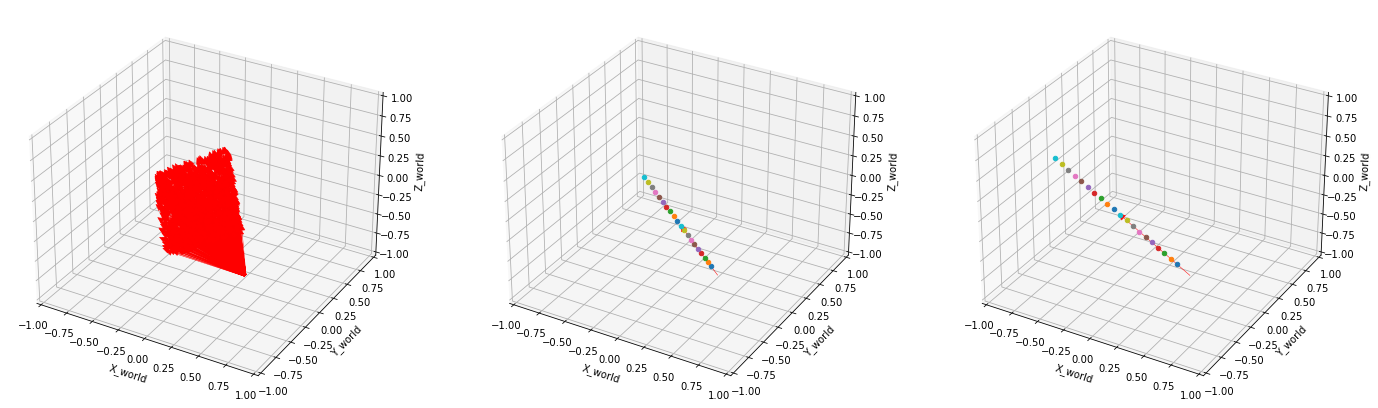

In [31]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)



for ray_o, ray_d in zip(sample_rays["ray_o"], sample_rays["ray_d"]):
    xs = [ray_o[0].item(), ray_o[0].item() + ray_d[0].item()]
    ys = [ray_o[1].item(), ray_o[1].item() + ray_d[1].item()]
    zs = [ray_o[2].item(), ray_o[2].item() + ray_d[2].item()]

    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

#####################
ax = fig.add_subplot(1, 3, 2, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)


ray_idx = 5
ray_o = sample_rays["ray_o"][ray_idx]
ray_d = sample_rays["ray_d"][ray_idx]

print(f"ray_o : {ray_o} / ray_d : {ray_d}")

N_points = 20
sample_points, sample_z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                depth_range.unsqueeze(0), N_points, det=True)

xs = [ray_o[0].item(), ray_o[0].item() + ray_d[0].item()]
ys = [ray_o[1].item(), ray_o[1].item() + ray_d[1].item()]
zs = [ray_o[2].item(), ray_o[2].item() + ray_d[2].item()]

a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points.squeeze(0):
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, y, z, cmap='Greens')

#####################
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)


ray_idx = 500
ray_o = sample_rays["ray_o"][ray_idx]
ray_d = sample_rays["ray_d"][ray_idx]

print(f"ray_o : {ray_o} / ray_d : {ray_d}")

N_points = 20
sample_points, sample_z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                depth_range.unsqueeze(0), N_points, det=True)

xs = [ray_o[0].item(), ray_o[0].item() + ray_d[0].item()]
ys = [ray_o[1].item(), ray_o[1].item() + ray_d[1].item()]
zs = [ray_o[2].item(), ray_o[2].item() + ray_d[2].item()]

a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points.squeeze(0):
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, y, z, cmap='Greens')

ray_o : tensor([-0.7912,  0.3882,  0.2349], device='cuda:0') / ray_d : tensor([ 0.1838, -0.8883,  0.6120], device='cuda:0')
ray_o : tensor([-0.7912,  0.3882,  0.2349], device='cuda:0') / ray_d : tensor([ 0.0212, -0.9015,  0.8179], device='cuda:0')


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


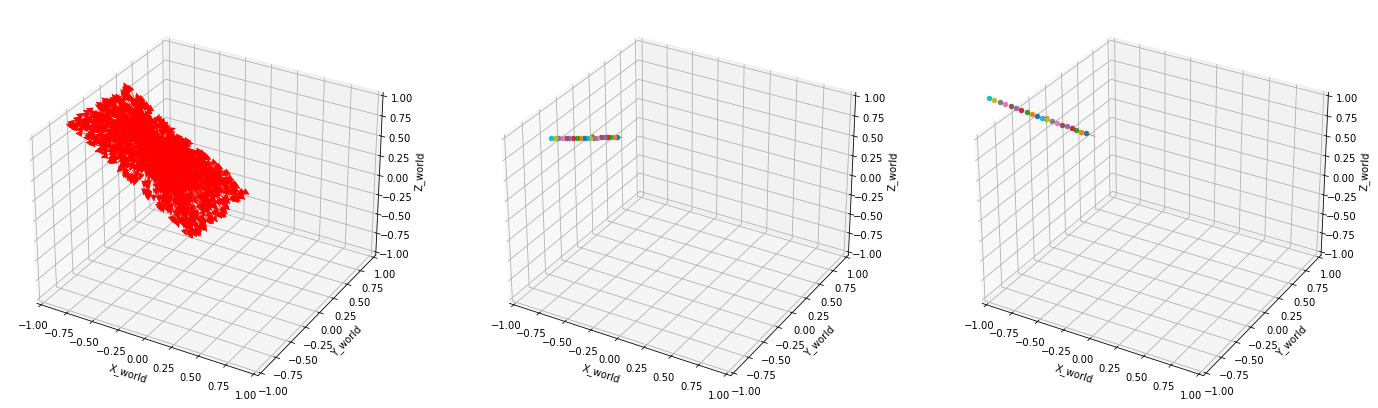

In [21]:
cam_idx = 70

tgt_img_path = seq_imgs[cam_idx]
tgt_img = Image.open("D:/CO3D/" + '/'.join(tgt_img_path.split('/')))

# 배치 사이즈를 1로 설정하여 테스트
c2w_ = torch.tensor(np.expand_dims(seq_c2ws[cam_idx], axis=0), dtype=torch.float32)
intrinsic_ =  torch.tensor(np.expand_dims(seq_intrinsics[cam_idx], axis=0), dtype=torch.float32)

data = {"rgb_path": seq_imgs[cam_idx],
        "camera": c2w_,
        "depth_range": depth_range}


ray_sampler = RaySampler(data, device, tgt_img.height, tgt_img.width, intrinsic_, c2w_)
sample_rays = ray_sampler.random_sample(N_samples, "uniform")


fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)



for ray_o, ray_d in zip(sample_rays["ray_o"], sample_rays["ray_d"]):
    xs = [ray_o[0].item(), ray_o[0].item() + ray_d[0].item()]
    ys = [ray_o[1].item(), ray_o[1].item() + ray_d[1].item()]
    zs = [ray_o[2].item(), ray_o[2].item() + ray_d[2].item()]

    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

#####################
ax = fig.add_subplot(1, 3, 2, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)


ray_idx = 5
ray_o = sample_rays["ray_o"][ray_idx]
ray_d = sample_rays["ray_d"][ray_idx]

print(f"ray_o : {ray_o} / ray_d : {ray_d}")

N_points = 20
sample_points, sample_z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                depth_range.unsqueeze(0), N_points, det=True)

xs = [ray_o[0].item(), ray_o[0].item() + ray_d[0].item()]
ys = [ray_o[1].item(), ray_o[1].item() + ray_d[1].item()]
zs = [ray_o[2].item(), ray_o[2].item() + ray_d[2].item()]

a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points.squeeze(0):
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, y, z, cmap='Greens')

#####################
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)


ray_idx = 500
ray_o = sample_rays["ray_o"][ray_idx]
ray_d = sample_rays["ray_d"][ray_idx]

print(f"ray_o : {ray_o} / ray_d : {ray_d}")

N_points = 20
sample_points, sample_z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                depth_range.unsqueeze(0), N_points, det=True)

xs = [ray_o[0].item(), ray_o[0].item() + ray_d[0].item()]
ys = [ray_o[1].item(), ray_o[1].item() + ray_d[1].item()]
zs = [ray_o[2].item(), ray_o[2].item() + ray_d[2].item()]

a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points.squeeze(0):
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, y, z, cmap='Greens')

[-0.7911627888679504, -0.9689850807189941] [0.38816186785697937, -0.6140508949756622] [0.23485785722732544, 1.133760154247284]


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


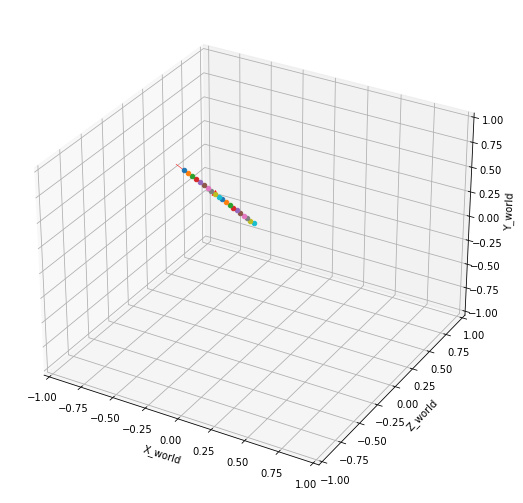

In [60]:
plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Z_world")
ax.set_zlabel("Y_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

xs = [ray_o[0].item(), ray_o[0].item() + ray_d[0].item()]
ys = [ray_o[1].item(), ray_o[1].item() + ray_d[1].item()]
zs = [ray_o[2].item(), ray_o[2].item() + ray_d[2].item()]

print(xs, ys, zs)
a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points.squeeze(0):
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, z, y, cmap='Greens')

# 카메라 좌표축에서의 ray와 sampling 시각화 (transform 이전)

In [32]:
W = tgt_img.width
H = tgt_img.height
print(f"Width : {W} / Height : {H}")

u, v = np.meshgrid(np.arange(W), np.arange(H))

# 이미지의 각 row들이 한 줄로 이어붙은 형태로 변환
# (H, W) --> (H*W)
u = u.reshape(-1).astype(dtype=np.float32)  # + 0.5    # add half pixel
v = v.reshape(-1).astype(dtype=np.float32)  # + 0.5

pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # [3(x+y+z), H*W]? 아니면 homogeneous coordinate라 1을 추가한 건지?
pixels = torch.from_numpy(pixels)
batched_pixels = pixels.unsqueeze(0).repeat(1, 1, 1)

# bmm : batch matrix-matrix product 
# [B, N, M] tensor * [B, M, P] tensor >>> [B, N, P]
rays_d = batched_pixels.transpose(1, 2).reshape(-1, 3)
rays_o = torch.tensor([0, 0, 0]).unsqueeze(0).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)

Width : 358 / Height : 478


In [33]:
c2w_

tensor([[[-0.7315,  0.5476, -0.4063,  0.6435],
         [-0.5514, -0.8256, -0.1201, -0.5295],
         [-0.4011,  0.1362,  0.9058, -0.3623],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [34]:
intrinsic_

tensor([[[520.4855,   0.0000, 179.0000,   0.0000],
         [  0.0000, 291.9570, 239.0000,   0.0000],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]]])

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


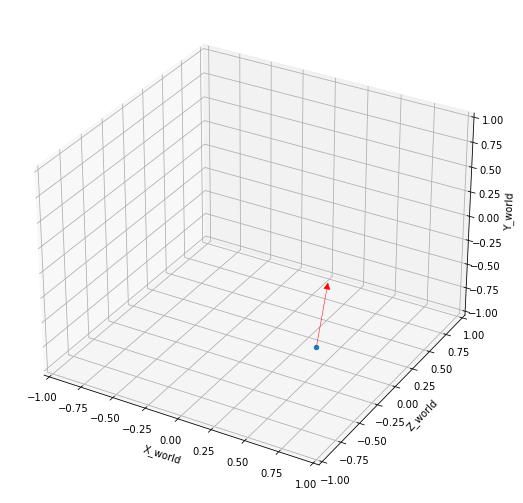

In [35]:
fig = plt.figure(figsize=(16, 9))

ax = plt.axes(projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Z_world")
ax.set_zlabel("Y_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

x, y, z = c2w_[0, :3, 3].numpy()
zx, zy, zz = c2w_[0, :3, 2].numpy()

xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, zs, ys, mutation_scale=15, 
            lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(x, z, y, cmap='Greens')

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


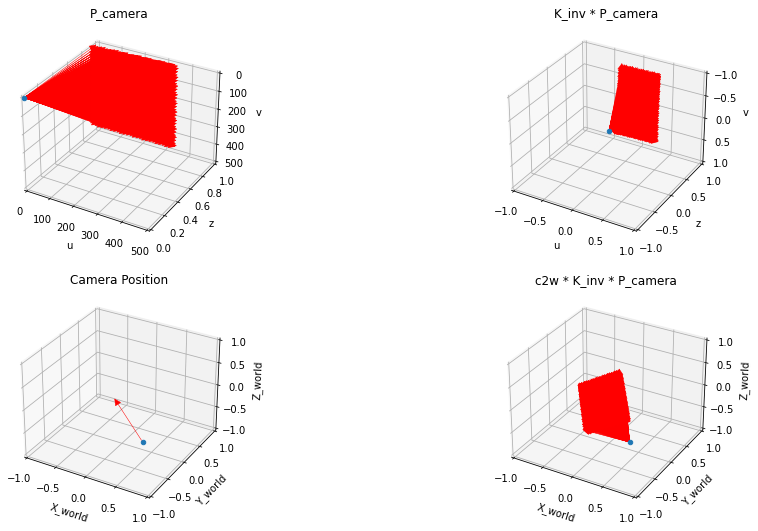

In [41]:
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(2, 2, 1, projection='3d')

ax.set_title("P_camera")

ax.set_xlabel("u")
ax.set_ylabel("z")
ax.set_zlabel("v")
ax.set_xlim3d(0, 500)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(500, 0)


# 카메라 기준 좌표계에서의 각 픽셀별 ray 시각화
for ray_o, ray_d in zip(rays_o[::100], rays_d[::100]):
    xs = [ray_o[0].item(), ray_d[0].item()]
    ys = [ray_o[1].item(), ray_d[1].item()]
    zs = [ray_o[2].item(), ray_d[2].item()]

    a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

x, y, z = ray_o[0].item(), ray_o[1].item(), ray_o[2].item()
ax.scatter3D(x, z, y, cmap='Greens')

#####################
ax = fig.add_subplot(2, 2, 3, projection='3d')

ax.set_title("Camera Position")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

x, y, z = c2w_[0, :3, 3].numpy()
zx, zy, zz = c2w_[0, :3, 2].numpy()

xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, ys, zs, mutation_scale=15, 
            lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(x, y, z, cmap='Greens')


#####################
ax = fig.add_subplot(2, 2, 2, projection='3d')

ax.set_title("K_inv * P_camera")

ax.set_xlabel("u")
ax.set_ylabel("z")
ax.set_zlabel("v")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(1, -1)

# intrinsic_inv만 곱한 ray 시각화
rays_d_intrinsic = torch.inverse(intrinsic_[:, :3, :3]).bmm(batched_pixels).transpose(1, 2)
rays_d_intrinsic = rays_d_intrinsic.reshape(-1, 3)

for ray_o, ray_d in zip(rays_o[::100], rays_d_intrinsic[::100]):
    xs = [ray_o[0].item(), ray_d[0].item()]
    ys = [ray_o[1].item(), ray_d[1].item()]
    zs = [ray_o[2].item(), ray_d[2].item()]

    a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

x, y, z = ray_o[0].item(), ray_o[1].item(), ray_o[2].item()
ax.scatter3D(x, z, y, cmap='Greens')

#####################
ax = fig.add_subplot(2, 2, 4, projection='3d')

ax.set_title("c2w * K_inv * P_camera")

ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

# intrinsic_inv와 c2w까지 곱한 ray 시각화
rays_d_world = rays_d.unsqueeze(0).transpose(1, 2)
rays_d_world = (c2w_[:, :3, :3].bmm(torch.inverse(intrinsic_[:, :3, :3])).bmm(batched_pixels)).transpose(1, 2)
rays_d_world = rays_d_world.reshape(-1, 3)
rays_o_world = c2w_[:, :3, 3].unsqueeze(1).repeat(1, rays_d_world.shape[0], 1).reshape(-1, 3)

for ray_o, ray_d in zip(rays_o_world[::100], rays_d_world[::100]):
    xs = [ray_o[0].item(), ray_o[0].item() + ray_d[0].item()]
    ys = [ray_o[1].item(), ray_o[1].item() + ray_d[1].item()]
    zs = [ray_o[2].item(), ray_o[2].item() + ray_d[2].item()]

    a = Arrow3D(xs, ys, zs, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

x, y, z = rays_o_world[0][0].item(), rays_o_world[0][1].item(), rays_o_world[0][2].item()
ax.scatter3D(x, y, z, cmap='Greens')

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


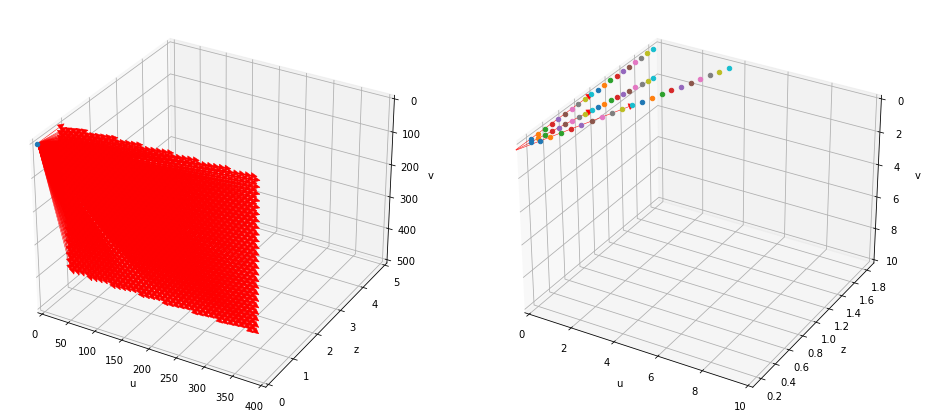

In [23]:
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_xlabel("u")
ax.set_ylabel("z")
ax.set_zlabel("v")
ax.set_xlim3d(0, 400)
ax.set_ylim3d(0, 5)
ax.set_zlim3d(500, 0)



for ray_o, ray_d in zip(rays_o[::100], rays_d[::100]):
    xs = [ray_o[0].item(), ray_d[0].item()]
    ys = [ray_o[1].item(), ray_d[1].item()]
    zs = [ray_o[2].item(), ray_d[2].item()]

    a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)

x, y, z = ray_o[0].item(), ray_o[1].item(), ray_o[2].item()
ax.scatter3D(x, z, y, cmap='Greens')

#####################
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.set_xlabel("u")
ax.set_ylabel("z")
ax.set_zlabel("v")
ax.set_xlim3d(0, 10)
# ax.set_ylim3d(-1, 1)
ax.set_zlim3d(10, 0)


ray_idx = 0
ray_o = rays_o[ray_idx]
ray_d = rays_d[ray_idx]

N_points = 20
sample_points, sample_z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                depth_range.unsqueeze(0), N_points, det=True)

xs = [ray_o[0].item(), ray_d[0].item()]
ys = [ray_o[1].item(), ray_d[1].item()]
zs = [ray_o[2].item(), ray_d[2].item()]

a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points.squeeze(0):
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, z, y, cmap='Greens')

ray_idx = 2
ray_o = rays_o[ray_idx]
ray_d = rays_d[ray_idx]

N_points = 20
sample_points, sample_z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                depth_range.unsqueeze(0), N_points, det=True)

xs = [ray_o[0].item(), ray_d[0].item()]
ys = [ray_o[1].item(), ray_d[1].item()]
zs = [ray_o[2].item(), ray_d[2].item()]

a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points.squeeze(0):
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, z, y, cmap='Greens')

ray_idx = W
ray_o = rays_o[ray_idx]
ray_d = rays_d[ray_idx]

N_points = 20
sample_points, sample_z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                depth_range.unsqueeze(0), N_points, det=True)

xs = [ray_o[0].item(), ray_d[0].item()]
ys = [ray_o[1].item(), ray_d[1].item()]
zs = [ray_o[2].item(), ray_d[2].item()]

a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points.squeeze(0):
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, z, y, cmap='Greens')

# Camera coordinate에서의 rays >>> World coordinate로 transform 시각화

In [26]:
seq_idx = 0

c2w = seq_c2ws[seq_idx].unsqueeze(0)
intrinsic = seq_intrinsics[seq_idx].unsqueeze(0)

print(c2w.shape)
print(intrinsic.shape)
print(rays_d.shape)


############


r_inv = c2w[:, :3, :3].squeeze(0)
t_inv = c2w[:, :3, 3].squeeze(0)
r = r_inv.T
t = r.matmul(-t_inv)

w2c = torch.eye(4, dtype=torch.float).unsqueeze(0)
w2c[:, :3, :3] = r
w2c[:, :3, 3] = t

print(w2c.shape)

torch.Size([1, 4, 4])
torch.Size([1, 4, 4])
torch.Size([172800, 3])
torch.Size([1, 4, 4])


In [28]:
rays_d_world = (c2w[:, :3, :3].matmul(torch.inverse(intrinsic[:, :3, :3])).matmul(rays_d.transpose(1, 0)))
# rays_d_world = (c2w[:, :3, :3].matmul(rays_d.transpose(1, 0)))
rays_d_world = rays_d_world.transpose(1, 2).reshape(-1, 3)
# rays_size = torch.square(rays_d_world).sum(dim=1).sqrt()
# rays_d_world = rays_d_world.div(rays_size.unsqueeze(1))
        
rays_o_world = c2w[:, :3, 3].unsqueeze(1).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)

print("rays_d in camera coordinate \n", rays_d[:5])
print("\nrays_d in world coordinate \n", rays_d_world[:5])

rays_d_back_2_camera = (intrinsic[:, :3, :3].bmm(w2c[:, :3, :3]).bmm(rays_d_world.unsqueeze(0).transpose(1, 2)))
rays_d_back_2_camera = rays_d_back_2_camera.squeeze(0).transpose(0, 1).round()
print("\nrays_d in camera coordinate again\n", rays_d_back_2_camera[:5])

rays_d in camera coordinate 
 tensor([[0., 0., 1.],
        [1., 0., 1.],
        [2., 0., 1.],
        [3., 0., 1.],
        [4., 0., 1.]])

rays_d in world coordinate 
 tensor([[0.3069, 0.5460, 1.0033],
        [0.3065, 0.5460, 1.0033],
        [0.3060, 0.5460, 1.0033],
        [0.3055, 0.5460, 1.0033],
        [0.3050, 0.5460, 1.0033]])

rays_d in camera coordinate again
 tensor([[-0., -0., 1.],
        [1., -0., 1.],
        [2., -0., 1.],
        [3., -0., 1.],
        [4., -0., 1.]])


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


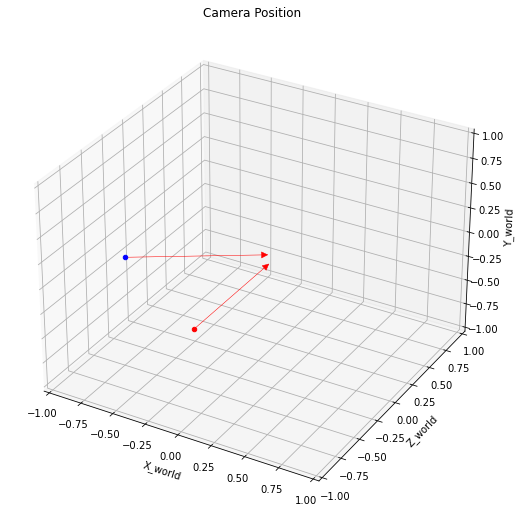

In [43]:
tgt_pose = seq_c2ws[0]
src_pose = seq_c2ws[20]

plt.figure(figsize=(16, 9))

ax = plt.axes(projection='3d')
ax.set_title("Camera Position")

ax.set_xlabel("X_world")
ax.set_ylabel("Z_world")
ax.set_zlabel("Y_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

x, y, z = tgt_pose[:3, 3].numpy()
zx, zy, zz = tgt_pose[:3, 2].numpy()

xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, zs, ys, mutation_scale=15, 
            lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(x, z, y, color='r')

x, y, z = src_pose[:3, 3].numpy()
zx, zy, zz = src_pose[:3, 2].numpy()

xs = [x, x+zx]
ys = [y, y+zy]
zs = [z, z+zz]
a = Arrow3D(xs, zs, ys, mutation_scale=15, 
            lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)
ax.scatter3D(x, z, y, color='b')

In [45]:
relative = np.linalg.inv(tgt_pose).dot(src_pose)
relative_rot = relative[:3, :3]

In [3]:
root_dir = "D:/"
mode = "train"
N_src = 3
category = ["teddybear"]
depth_range =  [0.2, 1.8]

train_dataset = CO3Ddataset(root_dir=root_dir, mode=mode, N_src=N_src, categories=category, 
                            bounded_crop=True, pose_normalize=False)

loading ['teddybear'] for train


In [4]:
len(train_dataset)

37356

In [5]:
train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                               worker_init_fn=lambda _: np.random.seed(),
                                               num_workers=4,
                                               pin_memory=True,
                                               sampler=train_sampler,
                                               shuffle=True if train_sampler is None else False)

In [7]:
ret = train_dataset.__getitem__(0)

D:/CO3D/teddybear/288_30468_58729/images/frame000001.jpg
torch.Size([3, 1902, 1069])
tensor([  65,   26,  863, 1090])
torch.Size([3, 1090, 863])
torch.Size([1902, 1069])
tensor([  65,   26,  863, 1090])
torch.Size([1090, 863])
torch.Size([3, 1904, 1070])
tensor([  82,   23,  848, 1109])
torch.Size([3, 1109, 848])
torch.Size([1904, 1070])
tensor([  82,   23,  848, 1109])
torch.Size([1109, 848])
torch.Size([3, 1914, 1076])
tensor([  84,   36,  890, 1132])
torch.Size([3, 1132, 890])
torch.Size([1914, 1076])
tensor([  84,   36,  890, 1132])
torch.Size([1132, 890])
torch.Size([3, 1909, 1073])
tensor([  56,   78,  887, 1129])
torch.Size([3, 1129, 887])
torch.Size([1909, 1073])
tensor([  56,   78,  887, 1129])
torch.Size([1129, 887])


In [8]:
for key in ret.keys():
    print(key)
    print(type(ret[key]))

rgb
<class 'torch.Tensor'>
mask
<class 'torch.Tensor'>
camera
<class 'torch.Tensor'>
rgb_path
<class 'str'>
src_rgbs
<class 'list'>
src_masks
<class 'list'>
src_cameras
<class 'list'>
src_rgb_paths
<class 'list'>
depth_range
<class 'torch.Tensor'>


In [9]:
ret["rgb_path"]

'D:/CO3D/teddybear/288_30468_58729/images/frame000001.jpg'

In [10]:
ret["src_rgb_paths"]

['teddybear/288_30468_58729/images/frame000003.jpg',
 'teddybear/288_30468_58729/images/frame000004.jpg',
 'teddybear/288_30468_58729/images/frame000005.jpg']

In [11]:
for item in ret['src_rgbs']:
    print(item.shape)
    print(type(item))

torch.Size([3, 1109, 848])
<class 'torch.Tensor'>
torch.Size([3, 1132, 890])
<class 'torch.Tensor'>
torch.Size([3, 1129, 887])
<class 'torch.Tensor'>


In [12]:
for item in ret['src_masks']:
    print(item.shape)
    print(type(item))

torch.Size([1109, 848])
<class 'torch.Tensor'>
torch.Size([1132, 890])
<class 'torch.Tensor'>
torch.Size([1129, 887])
<class 'torch.Tensor'>


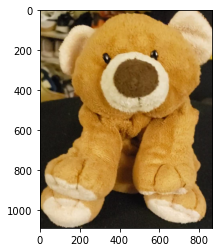

In [20]:
plt.imshow(ret['rgb'].numpy().transpose(1, 2, 0))

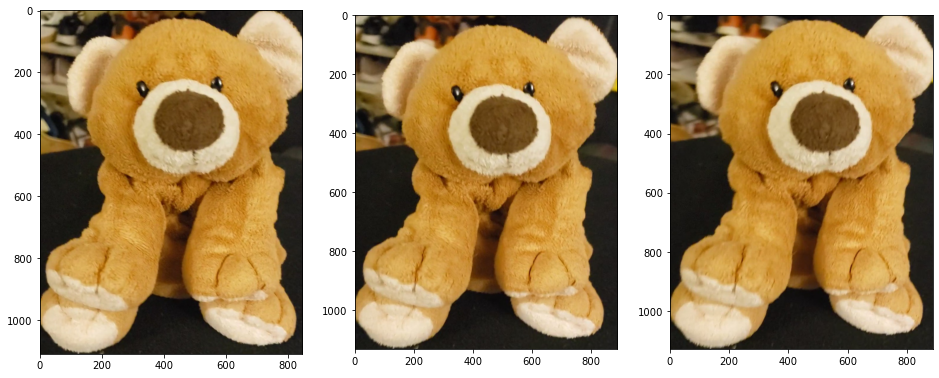

In [14]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(ret['src_rgbs'][0].numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(ret['src_rgbs'][1].numpy().transpose(1, 2, 0))
plt.subplot(1, 3, 3)
plt.imshow(ret['src_rgbs'][2].numpy().transpose(1, 2, 0))

In [15]:
src_camera = ret['src_cameras'][0]
print(src_camera, len(src_camera))

img_size = src_camera[:2]
intrinsic = src_camera[2:18].reshape(4, 4)
c2w = src_camera[18:].reshape(4, 4)

tensor([ 1.9040e+03,  1.0700e+03,  2.7467e+03,  0.0000e+00,  5.3500e+02,
         0.0000e+00,  0.0000e+00,  8.6746e+02,  9.5200e+02,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00, -9.9956e-01, -3.0989e-03,
         2.9378e-02, -8.6846e-02,  3.3180e-03, -9.9997e-01,  7.4118e-03,
         2.0050e+00,  2.9354e-02,  7.5060e-03,  9.9954e-01, -6.4890e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]) 34


In [16]:
img_size.type(torch.int)

tensor([1904, 1070], dtype=torch.int32)

In [17]:
intrinsic.type(torch.int)

tensor([[2746,    0,  535,    0],
        [   0,  867,  952,    0],
        [   0,    0,    1,    0],
        [   0,    0,    0,    1]], dtype=torch.int32)

In [18]:
c2w

tensor([[-9.9956e-01, -3.0989e-03,  2.9378e-02, -8.6846e-02],
        [ 3.3180e-03, -9.9997e-01,  7.4118e-03,  2.0050e+00],
        [ 2.9354e-02,  7.5060e-03,  9.9954e-01, -6.4890e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [19]:
ret['depth_range']

tensor([ 0.0000, 14.8351], dtype=torch.float64)